In [41]:
from kneed import DataGenerator, KneeLocator
from quick_extract import *
from get_data import *
from load_rhd import *
import matplotlib.pyplot as plt
from ExtractRecordings.manual.simple_sort import*
import pandas as pd
from PostProcessing.tools.utils import *
import json
fs = 30e3
n_blocs = 5
bin_width = 0.005


In [1]:
import tkinter


<module 'tkinter' from '/mnt/working2/felicie/Python_theremin/Analyse/Analyse/env/lib/python3.8/site-packages/tkinter/__init__.py'>


In [102]:
def read_npz_file(file_path):
    format_tt = dict()
    # Load the .npz file
    npz_file = np.load(file_path, allow_pickle=True)
    
    # Access the arrays stored in the .npz file
    for array_name in npz_file:
        array_data = npz_file[array_name]
        format_tt.append(array_data)
    return format_tt
        

In [38]:
import numpy as np

def read_npz_file(file_path):
    format_tt = dict()  # Initialize an empty dictionary to store the arrays
    
    # Load the .npz file
    npz_file = np.load(file_path, allow_pickle=True)
    
    # Access the arrays stored in the .npz file
    for array_name in npz_file:
        array_data = npz_file[array_name]
        format_tt[array_name] = array_data  # Assign the array to the dictionary with the array name as the key
    
    return format_tt



In [39]:
def create_data_v3(path, bin_width, n_blocs):
    """"
    Fonction ecrite en urgence pour le cas où : on a pas les mocks triggers ET où j'ai du créer les tt.npz avec create_tt()
    Mettre en forme les données en :
    data.npy qui contient les spikes binnés pour chaque cluster
    features.npy qui contient les infos sur chaque bin
    
    input : path contenant le tt.npz et tout
            bin_width
    """
    tt = np.load(path+"/tt.npz", allow_pickle=True)
    tt = tt['arr_0'].item()

    #data = pd.read_hdf(path+'/data.h5')
    
    file = path+'/recording_length.bin'
    with open(file, 'rb') as file:
        recording_length = file.read()
    recording_length = recording_length.decode('utf-8')

    # Extract only the numbers using a simple filter
    recording_length = int(''.join(filter(str.isdigit, recording_length)))

    print(recording_length)
    #extraire recording_length OK ca marche

    #avec les clusters et la classe de Flavien
    spike = Spikes(path, recording_length=int(recording_length))
    
    #id = tt.files


    ##NEURO
    t_spk, c_spk = [], [] #spike times, cluster
    #for cluster in range(spike.get_n_clusters()):
    for cluster in range(int(spike.n_clusters)):
        t_spk.append(spike.get_spike_times(cluster)) #spikes times
        c_spk.append(np.full_like(t_spk[cluster], cluster))
    t_spk = np.hstack(t_spk)
    c_spk = np.hstack(c_spk)

    # mettre en secondes 
    t_spk = t_spk/fs
    c_spk = c_spk/fs


    ## faire les bins : 
    min_value = t_spk.min()  # Get the minimum value of 'spike_time'
    max_value = t_spk.max()  # Get the maximum value of 'spike_time'

    bins = np.arange(min_value, max_value + bin_width, bin_width)  # Define custom bin edges

    ## histogramme par cluster
    unique_clusters = np.unique(c_spk)

    histograms_per_cluster = {}

    for cluster in unique_clusters:
        spike_times_cluster = [time for time, clus in zip(t_spk, c_spk) if clus == cluster]
        # Now spike_times_cluster contains spike times for the current cluster
        
        # Perform histogram for the current cluster
        hist, bin_edges = np.histogram(spike_times_cluster, bins=bins)
        histograms_per_cluster[cluster] = (hist, bin_edges)

    print(histograms_per_cluster)
    data = [histograms_per_cluster[key][0] for key in histograms_per_cluster]
    np.save(path+'/data.npy', data)


    #### TRIGGERS

    t_stim, f_stim, b_stim, type_stim= [], [], [], [] # stimulus times, frequencies, bloc, type_stim(tracking/playback/mock)
    for bloc in range(n_blocs):
        print('traitement du bloc', bloc)
        
        # Tracking
        #extraire les triggers et les freq
        print(tt['tr_'+str(bloc)][1])
        t_stim.append(tt['tr_'+str(bloc)][1]) #time triggers for bloc 
        f_stim.append(tt['tr_'+str(bloc)][0]) #frequencies for bloc
        b_stim.append(np.full_like(tt['tr_'+str(bloc)][1], bloc))
        type_stim.append(np.full(len(tt['tr_'+str(bloc)][1]), 0))
        
        # Playback
        t_stim.append(tt['pb_'+str(bloc)][1]) #time triggers for bloc 
        f_stim.append(tt['pb_'+str(bloc)][0]) #frequencies for bloc
        b_stim.append(np.full_like(tt['pb_'+str(bloc)][1], bloc))
        type_stim.append(np.full(len(tt['pb_'+str(bloc)][1]), 1))
        
        
    t_stim = np.hstack(t_stim)
    f_stim = np.hstack(f_stim)
    b_stim = np.hstack(b_stim)
    type_stim = np.hstack(type_stim)
    
    unique_tones = sorted(np.unique(f_stim))


    t_stim = t_stim/fs

    #need to interpolate between two stims to get the frequency in between
    # 1. True stims
    stimulus_presence = np.zeros(len(bins) - 1, dtype=bool)
    interpolated_freq = np.zeros(len(bins) - 1)

    previous_frequency = None
    for i in range(len(bins) - 1):
        bin_start = bins[i]
        bin_end = bins[i + 1]

        # Check if any stimuli fall within the current bin
        stimuli_in_bin = (t_stim >= bin_start) & (t_stim < bin_end)

        if np.any(stimuli_in_bin):
            # If stimuli are present, set stimulus_presence to True for this bin
            stimulus_presence[i] = True

            # Calculate the frequency associated with the bin (assuming frequency remains constant within the bin)
            # You can simply take the frequency of the first stimulus within the bin
            interpolated_freq[i] = f_stim[stimuli_in_bin][0]
            previous_frequency = interpolated_freq[i]  # Update previous frequency
        else:
            # If no stimulus in the bin, set bin_frequencies to the previous frequency
            if previous_frequency is not None:
                interpolated_freq[i] = previous_frequency
                
    interpolated_blocks = np.interp(bins, t_stim, b_stim)
    interpolated_type_stim = np.interp(bins, t_stim, type_stim)


    # Initialize previous frequency
    previous_frequency = None

    
    # Create a dictionary to store information for each time bin
    features = {}
    for i, bin in enumerate(bins[:-1]):
        features[bin] = {
            'Played_frequency': interpolated_freq[i],
            'Block': interpolated_blocks[i],
            'Condition': interpolated_type_stim[i],
            'Frequency_changes': stimulus_presence[i],
        }
        
        
        
    features = list(features.values())
    np.save(path+'/features.npy', features)
    
    np.save(path+'/unique_tones.npy', unique_tones)

    #with open(path+'/features.json', 'w') as json_file:
        #json.dump(features, json_file)   
        
        
    print('all izz well')
    return data
    

In [45]:
path = '/mnt/working2/felicie/Python_theremin/Analyse/Analyse/Experiment/BURRATA/BURRATA_20240501_SESSION_00/headstage_0'
create_data_v3(path, bin_width, n_blocs-1)

90234624
{0.0: (array([0, 0, 0, ..., 0, 0, 0]), array([3.33333333e-05, 5.03333333e-03, 1.00333333e-02, ...,
       3.00781503e+03, 3.00782003e+03, 3.00782503e+03])), 3.3333333333333335e-05: (array([0, 0, 0, ..., 0, 0, 0]), array([3.33333333e-05, 5.03333333e-03, 1.00333333e-02, ...,
       3.00781503e+03, 3.00782003e+03, 3.00782503e+03])), 6.666666666666667e-05: (array([0, 0, 0, ..., 0, 1, 0]), array([3.33333333e-05, 5.03333333e-03, 1.00333333e-02, ...,
       3.00781503e+03, 3.00782003e+03, 3.00782503e+03])), 0.0001: (array([5, 3, 4, ..., 0, 3, 0]), array([3.33333333e-05, 5.03333333e-03, 1.00333333e-02, ...,
       3.00781503e+03, 3.00782003e+03, 3.00782503e+03])), 0.00013333333333333334: (array([0, 0, 0, ..., 0, 4, 1]), array([3.33333333e-05, 5.03333333e-03, 1.00333333e-02, ...,
       3.00781503e+03, 3.00782003e+03, 3.00782503e+03])), 0.00016666666666666666: (array([0, 0, 0, ..., 2, 3, 1]), array([3.33333333e-05, 5.03333333e-03, 1.00333333e-02, ...,
       3.00781503e+03, 3.00782003e

[array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 1, 0]),
 array([5, 3, 4, ..., 0, 3, 0]),
 array([0, 0, 0, ..., 0, 4, 1]),
 array([0, 0, 0, ..., 2, 3, 1]),
 array([0, 0, 0, ..., 1, 1, 0]),
 array([0, 0, 0, ..., 2, 3, 1]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([4, 3, 3, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([4, 4, 3, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 4, 0]),
 array([4, 4, 4, ..., 0, 5, 0]),
 array([4, 3, 3, ..., 0, 2, 0]),
 array([4, 4, 3, ..., 2, 4, 1]),
 array([4, 4, 4, ..., 0, 3, 1]),
 array([0,

In [40]:
tt = np.load('/mnt/working2/felicie/Python_theremin/Analyse/Analyse/Experiment/BURRATA/BURRATA_20240501_SESSION_00/tt.npz', allow_pickle=True)

In [3]:
features = np.load('/mnt/working2/felicie/Python_theremin/Analyse/Analyse/Experiment/BURRATA/BURRATA_20240503_SESSION_02/headstage_1/features.npy', allow_pickle = True)

In [4]:
n_blocs  =6
tt = tt['arr_0'].item()
t_stim, f_stim, b_stim, type_stim= [], [], [], [] # stimulus times, frequencies, bloc, type_stim(tracking/playback/mock)
for bloc in range(n_blocs):
    print('traitement du bloc', bloc)
        
        # Tracking
        #extraire les triggers et les freq
    print(tt['tr_'+str(bloc)][1])
    t_stim.append(tt['tr_'+str(bloc)][1]) #time triggers for bloc 
    f_stim.append(tt['tr_'+str(bloc)][0]) #frequencies for bloc
        
        # Playback
    t_stim.append(tt['pb_'+str(bloc)][1]) #time triggers for bloc 
    f_stim.append(tt['pb_'+str(bloc)][0]) #frequencies for bloc

traitement du bloc 0
[  94392  106472  156232 ... 8232295 8232855 8242695]
traitement du bloc 1
[ 8246535  8286854  8288054 ... 17608995 17611075 17612675]
traitement du bloc 2
[17614755 17616435 17618355 17620755 17623395 17668915 17669155 17669715
 17709395 17711475 17712675 17713395 17717875 17718675 17729475 17732035
 17735875 17754675 17762195 17786515 17788995 17791235 17816515 17850115
 17853395 17859235 17862675 17867155 17868275 17871715 17871875 17872035
 17891635 17960355 17964515 17970275 17977955 17978515 17982515 17983555
 17985475 17990675 17993395 17994995 17996515 18011154 18011714 18037714
 18041154 18043554 18045634 18063634 18075954 36095277 36117677 36120397
 36129597 36131997 36133517 36135197 36137437 36141037 36142237 36146797
 36155597 36157677 36160877 36183197 36190317 36239437 36239677 36249917
 36332236 36332477 36337516 36337676 36338476 36340076 36340876 36341116
 36341996 36350636 36355276 36360716 36361836 36491996 36506636 36648956
 36649676 36649916 3

In [5]:
path = '/mnt/working2/felicie/Python_theremin/Analyse/Analyse/Experiment/BURRATA/BURRATA_20240503_SESSION_02/headstage_1'

file = path+'/recording_length.bin'
with open(file, 'rb') as file:
        recording_length = file.read()
recording_length = recording_length.decode('utf-8')

    # Extract only the numbers using a simple filter
recording_length = int(''.join(filter(str.isdigit, recording_length)))


spike = Spikes(path, recording_length=int(recording_length))
t_spk = []
for cluster in range(int(spike.n_clusters)):
        t_spk.append(spike.get_spike_times(cluster)) #spikes times

In [6]:
from zetapy.dependencies import *

In [29]:
tt = np.load(path+"/tt.npz", allow_pickle=True)
tt = tt['arr_0'].item()

    #data = pd.read_hdf(path+'/data.h5')
    
file = path+'/recording_length.bin'
with open(file, 'rb') as file:
    recording_length = file.read()
recording_length = recording_length.decode('utf-8')

    # Extract only the numbers using a simple filter
recording_length = int(''.join(filter(str.isdigit, recording_length)))

print(recording_length)
spk = Spikes(path, recording_length=int(recording_length))

126310144


In [35]:
gc = check_responsiveness(arrEventTimes, spk, clusters=None, tag=None)

  0%|          | 0/32 [00:00<?, ?it/s]

Please upgrade to the new version of the zeta-test called zetatest, as it has improved statistical sensitivity.
If you wish to continue using getZeta for legacy purposes and want to suppress this message, you can call getZeta with the optional parameter boolSuppressUpgradeMessage=True


  3%|▎         | 1/32 [03:46<1:56:51, 226.19s/it]

Please upgrade to the new version of the zeta-test called zetatest, as it has improved statistical sensitivity.
If you wish to continue using getZeta for legacy purposes and want to suppress this message, you can call getZeta with the optional parameter boolSuppressUpgradeMessage=True


  3%|▎         | 1/32 [05:14<2:42:40, 314.86s/it]


KeyboardInterrupt: 

In [31]:
arrEventTimes = np.hstack(t_stim)
vecSpikeTimes = t_spk[8]
arrEventTimes = arrEventTimes.astype(float)

In [33]:
def check_responsiveness(triggers, spikes, clusters=None, tag=None):
    """
    Vérifie qu'une unité répond aux stimuli.
    """
    good_clusters = list()
    if clusters is not None:
        iterator = clusters
    else:
        iterator = list(range(spikes.get_n_clusters()))
    for cluster in tqdm(iterator):
        x = spikes.get_spike_times(cluster=cluster)
        a, b = getZeta(x * (1 / 30000), triggers * (1 / 30000))
        if a < 0.001:
            good_clusters.append(cluster)
    good_clusters = np.array(good_clusters)
    if tag is not None:
        filename = f"good_clusters_{tag}.npy"
    else:
        filename = "good_clusters.npy"

    return good_clusters

In [24]:
tt = np.load(path+'tt.npz')


SyntaxError: invalid syntax (2539516074.py, line 2)

In [25]:
tt

{'n_iter': 6,
 'recording_length': 26310144,
 'tr_0': [array([ 617.,  715.,  617., ..., 2317., 3601., 3109.]),
  array([  94392,  106472,  156232, ..., 8232295, 8232855, 8242695])],
 'tr_1': [array([2000., 2317., 2684., ..., 1727., 2000., 1727.]),
  array([ 8246535,  8286854,  8288054, ..., 17608995, 17611075, 17612675])],
 'tr_2': [array([ 2317.,  2684.,  3109.,  2684.,  2317.,  2000.,  2317.,  2684.,
          3601.,  3109.,  2684.,  2317.,  2684.,  2317.,  2684.,  2317.,
          2684.,  3109.,  3601.,  4172.,  3601.,  3109.,  3601.,  3109.,
          3601.,  4172.,  3601.,  3109.,  2684.,  2317.,  2000.,  1727.,
          1490.,  1287.,  1490.,  1287.,  1490.,  1287.,  1490.,  1287.,
          1111.,   959.,  1111.,   959.,  1111.,  1287.,  1490.,  1287.,
          1111.,   959.,  1111.,   959.,   828.,   959.,   828.,   959.,
          1111.,   959.,  1111.,   959.,  1111.,  1287.,  1111.,  1287.,
          1111.,  1287.,  1111.,  1287.,  1111.,  1287.,  1490.,  1727.,
          

In [21]:
vecTime, vecRate, dIFR = ifr(vecSpikeTimes, arrEventTimes)

In [129]:
path = '/mnt/working2/felicie/Python_theremin/Analyse/Analyse/Experiment/BURRATA/BURRATA_20240503_SESSION_02/headstage_1'
bin_width = 0.01
create_data_v3(path, bin_width, 5)

126310144
{0.0: (array([0, 0, 0, ..., 0, 0, 0]), array([3.33333333e-05, 1.00333333e-02, 2.00333333e-02, ...,
       4.21032003e+03, 4.21033003e+03, 4.21034003e+03])), 3.3333333333333335e-05: (array([8, 6, 7, ..., 8, 7, 3]), array([3.33333333e-05, 1.00333333e-02, 2.00333333e-02, ...,
       4.21032003e+03, 4.21033003e+03, 4.21034003e+03])), 6.666666666666667e-05: (array([8, 8, 8, ..., 5, 7, 3]), array([3.33333333e-05, 1.00333333e-02, 2.00333333e-02, ...,
       4.21032003e+03, 4.21033003e+03, 4.21034003e+03])), 0.0001: (array([2, 5, 2, ..., 1, 2, 5]), array([3.33333333e-05, 1.00333333e-02, 2.00333333e-02, ...,
       4.21032003e+03, 4.21033003e+03, 4.21034003e+03])), 0.00013333333333333334: (array([8, 7, 8, ..., 7, 7, 5]), array([3.33333333e-05, 1.00333333e-02, 2.00333333e-02, ...,
       4.21032003e+03, 4.21033003e+03, 4.21034003e+03])), 0.00016666666666666666: (array([5, 8, 6, ..., 3, 5, 4]), array([3.33333333e-05, 1.00333333e-02, 2.00333333e-02, ...,
       4.21032003e+03, 4.21033003

[array([0, 0, 0, ..., 0, 0, 0]),
 array([8, 6, 7, ..., 8, 7, 3]),
 array([8, 8, 8, ..., 5, 7, 3]),
 array([2, 5, 2, ..., 1, 2, 5]),
 array([8, 7, 8, ..., 7, 7, 5]),
 array([5, 8, 6, ..., 3, 5, 4]),
 array([0, 0, 0, ..., 5, 2, 5]),
 array([0, 1, 6, ..., 0, 0, 1]),
 array([5, 7, 7, ..., 0, 0, 0]),
 array([7, 7, 9, ..., 7, 6, 6]),
 array([8, 8, 7, ..., 4, 3, 1]),
 array([0, 0, 0, ..., 6, 1, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([3, 4, 2, ..., 0, 2, 0]),
 array([8, 7, 9, ..., 0, 0, 0]),
 array([5, 4, 5, ..., 3, 3, 1]),
 array([8, 5, 3, ..., 7, 0, 1]),
 array([1, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 6, 7, 6]),
 array([3, 3, 2, ..., 7, 8, 6]),
 array([7, 6, 4, ..., 2, 1, 1]),
 array([0, 0, 1, ..., 1, 0, 0]),
 array([0, 0, 0, ..., 0, 5, 0]),
 array([8, 8, 7, ..., 7, 7, 0]),
 array([0, 0, 0, ..., 5, 0, 2]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([3, 0, 0, ..., 5, 9, 6]),
 array([7, 8, 8, ..., 0, 0, 1]),
 array([0, 0, 0, ..., 1, 2, 3]),
 array([8, 8, 6, ..., 0, 1, 3]),
 array([8,

In [85]:
path = '/mnt/working2/felicie/Python_theremin/Analyse/Analyse/Experiment/BURRATA/BURRATA_20240503_SESSION_02/headstage_1'
data = np.load(path+'/data.npy')
features = np.load(path+'/features.npy', allow_pickle=True)
unique_tones = np.load(path+'/unique_tones.npy')
gc = np.arange(32)

In [86]:
from format_data import *
bin_width = 0.01
t_pre = 0.2
t_post = 0.5
psth_bins = np.arange(-t_pre, t_post + bin_width, bin_width)
tracking, playback = get_mean_neurone(data, features, t_pre, t_post, bin_width, gc)
#plot_mean_psth(tracking, playback, psth_bins, 'psth', remove_baseline = False)

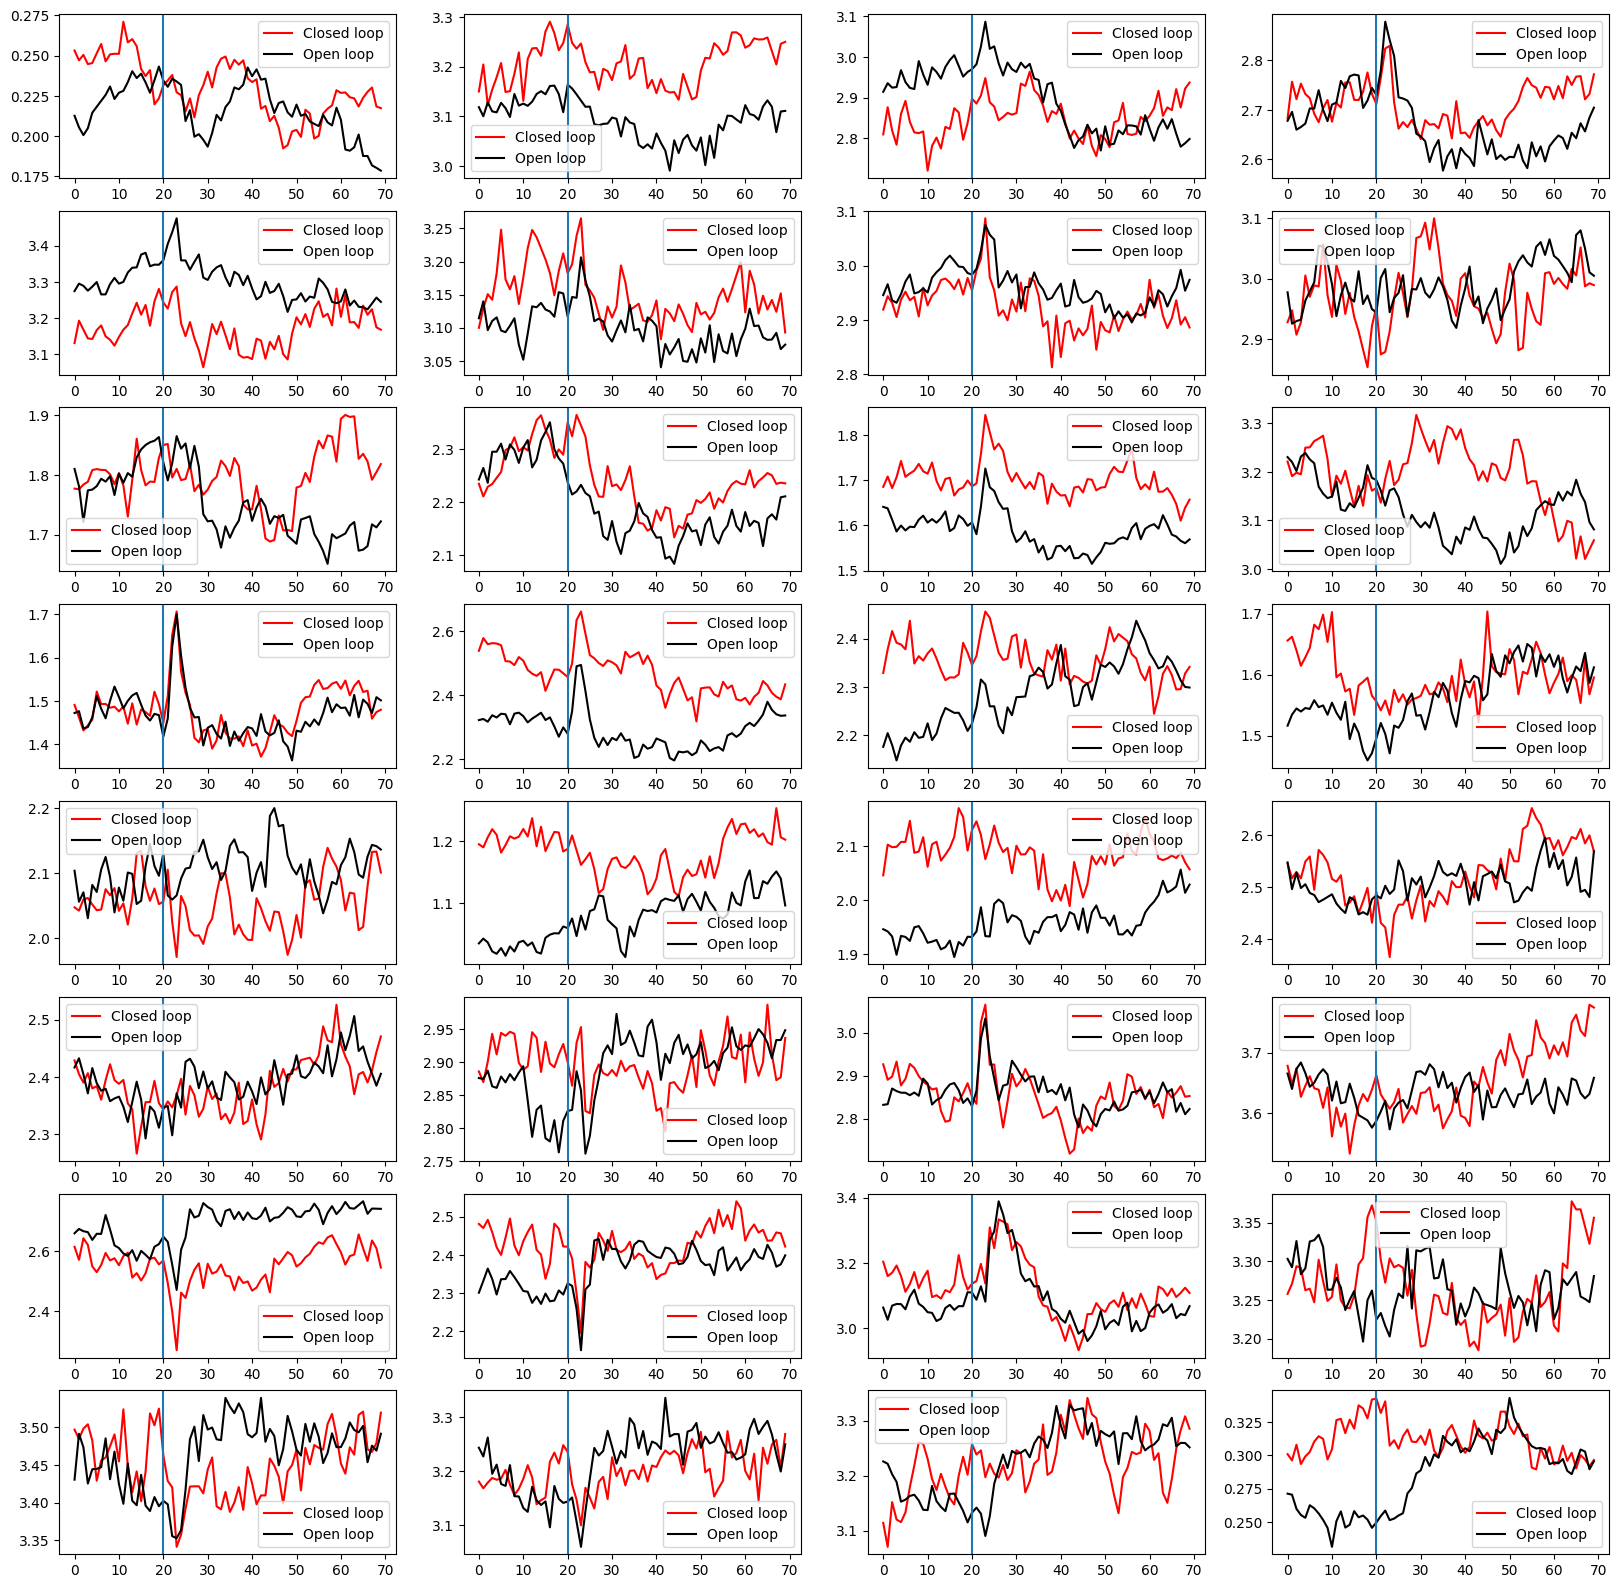

In [87]:
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(20, 20))

for i, ax in enumerate(axes.flat):
    ax.plot(tracking[i], c = 'red', label = 'Closed loop')
    ax.plot(playback[i], c = 'black', label = 'Open loop')
    ax.axvline(x = t_pre/bin_width)
    ax.legend()

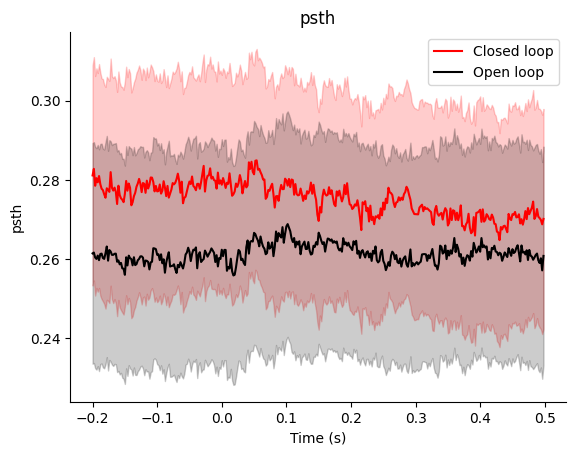

all izz well


In [97]:
plot_mean_psth(tracking, playback, psth_bins, 'psth', remove_baseline = False)

In [86]:
total = 0
for elt in features:
    if elt['Condition']==0:
        total+=1
print(total)

14


In [77]:

tracking, playback=[], []    
for cluster in range(1):
    mean_psth_tr, mean_psth_pb = [], []
    for bin in range(len(features)):
        if features[bin]['Frequency_changes']>0 and features[bin]['Condition']==0:
            if bin-int(t_pre/bin_width)>0:
                mean_psth_tr.append(data[cluster][bin-int(t_pre/bin_width):bin+int(t_post/bin_width)])
        if features[bin]['Frequency_changes']>0 and features[bin]['Condition']==1:
            if bin-int(t_pre/bin_width)>0:
                mean_psth_pb.append(data[cluster][bin-int(t_pre/bin_width):bin+int(t_post/bin_width)])
    #tracking.append(np.nanmean(mean_psth_tr, axis=0))
    #playback.append(np.nanmean(mean_psth_pb, axis=0))

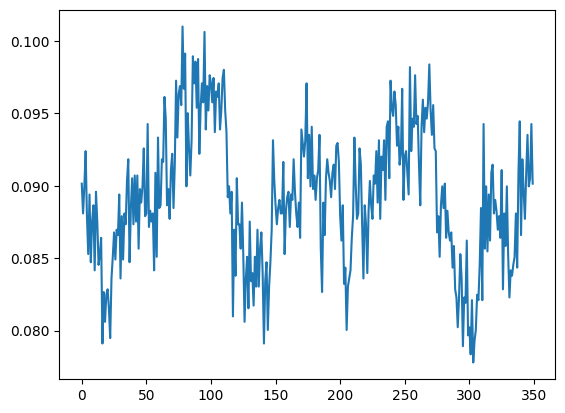

In [81]:
pb = np.nanmean(mean_psth_pb, axis=0)
plt.plot(pb)
            

In [8]:
from tonotopy import *
#heatmaps = get_tonotopy(data, features, 0.2, 0.3, bin_width, gc, unique_tones, 1, 1, 'tracking', path+'/heatmaps_tracking.npy')
#plot_heatmap_bandwidth(heatmaps,threshold, gc,unique_tones, min_freq, max_freq, bin_width, psth_bins, t_pre,path, condition)
        

[134.         133.73412977 133.         132.         131.
 130.         129.33039215 129.         128.36525334 129.
 130.         131.         132.         133.         134.
 135.         136.         136.43666176 136.         135.3677142
 135.         134.25150246 134.        ] [20.03727871 20.         19.53595906 19.67435447 19.50835239 19.69995181
 19.         18.66846583 18.         17.65180291 17.34220385 17.25462284
 17.47377663 17.69897166 17.58777621 17.70381899 17.90988612 18.
 18.26071579 19.         19.49881491 20.         20.03727871]
[114.         113.         112.         111.         110.
 109.         108.         107.57366157 108.         109.
 110.         111.         112.         113.         114.
 114.74665072 114.        ] [18.19157159 18.54230364 18.22513834 18.18830122 18.3341112  18.22060398
 18.16226448 18.         17.76131181 17.67534831 17.37633889 17.64605034
 17.49306524 17.17404079 17.76412373 18.         18.19157159]
[121.         120.         119.      

'all izz well'

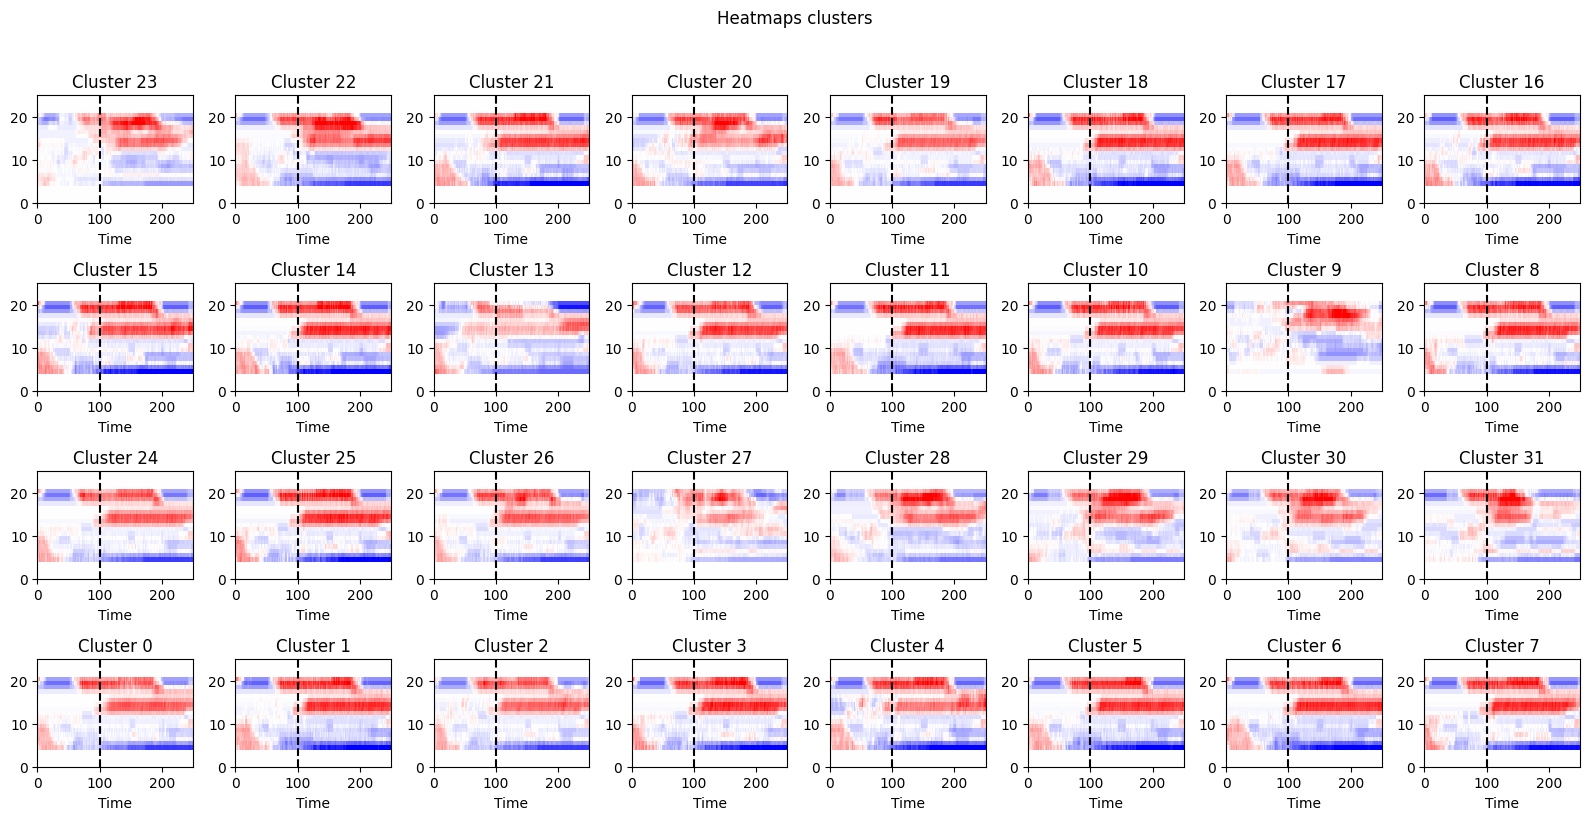

In [10]:
import numpy as np
heatmaps = np.load(path+'/heatmaps_tracking.npy')
t_pre = 0.2
t_post = 0.3
psth_bins = np.arange(-t_pre, t_post + bin_width, bin_width)
#plot_heatmap(heatmaps, psth_bins, gc, unique_tones, 0, 1, 'heatmap_tracking')
plot_heatmap_bandwidth(heatmaps,1, gc,unique_tones, 3, 3, bin_width, psth_bins, 0.2,path, 'tracking')